# Connect and authorize google drive

In [ ]:
from google.colab import drive
drive.mount('/content/gdrive')
!ls

Mounted at /content/gdrive
gdrive	sample_data


# Libraries

In [ ]:
import os
import sys
import pickle

import time
import math
import copy

import wget

import numpy as np
import pandas as pd

from scipy.stats import binned_statistic_2d
from scipy import stats

from astropy.io import fits
from astropy.wcs import WCS
from astropy    import units as u
from astropy.coordinates import SkyCoord
from astropy.table import Table, join
import astropy.constants as const

import plotly.express as px
import plotly.graph_objects as go

import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1.inset_locator import inset_axes
import matplotlib as mpl
from matplotlib.colors import LogNorm
from mpl_toolkits.axes_grid1 import make_axes_locatable
import matplotlib.gridspec as gridspec

import torch

from pathlib import Path

In [ ]:
plt.rcParams['mathtext.fontset'] = 'cm'
plt.rcParams['font.family'] = 'STIXGeneral'

# Paths

In [ ]:
gaia_path = Path('/content/gdrive/MyDrive/Colab Notebooks/gaia/')
ml_path = Path('/content/gdrive/MyDrive/Colab Notebooks/ML')
gaskap_path = Path('/content/gdrive/MyDrive/Colab Notebooks/GASKAP')

ml_data_path = ml_path / 'data'
data_path = gaia_path / 'data'
dust_data_path = data_path / 'edenhofer'
gaskap_data_path = gaskap_path / 'data'

local_bubble_data_path = data_path / 'oneill'

gaskap_hires_data_path = gaskap_data_path / 'hires'
gaskap_hires_result_path = gaskap_hires_data_path / 'results'

GASS_data_path = gaskap_data_path / 'GASS'

dynamics_file = data_path / 'galah_dr4_vac_dynamics_240705.fits'
allstar_file = data_path / 'galah_dr4_allstar_240705.fits'
gaia_catalog_file = data_path / 'stellar_params_catalog-1kpc.fits'
gaia_catalog_file = data_path / 'stars_MC_fg.fits'

# Fcn

In [ ]:
vlsr_sun = 15.17 # km/s, see paper GALAH DR4 https://arxiv.org/pdf/2409.19858 Section 7.2.2


# Create velocity range around the central velocity
velocity_range = np.linspace(-100., 100., 5000)

# Define the Gaussian function
def gaussian_std(x, amp, center, std):
    return amp * np.exp(-(x - center)**2 / (2 * std**2))

In [ ]:
def make_dir(path):
    if not os.path.exists(path):
        os.makedirs(path)


def download_galah_data(save_path, sobject_id):
    sobject_id = str(sobject_id)
    output_star_id_file = save_path / f'{sobject_id}_allstar_fit_spectrum.fits'
    # print(output_star_id_file)
    save_path = str(save_path)

    if not os.path.exists(output_star_id_file):
        url = f'https://cloud.datacentral.org.au/teamdata/GALAH/public/GALAH_DR4/analysis_products_allstar/{sobject_id[:6]}/{sobject_id}/{sobject_id}_allstar_fit_spectrum.fits'
        wget.download(url, out=save_path)

        url = f'https://cloud.datacentral.org.au/teamdata/GALAH/public/GALAH_DR4/analysis_products_allstar/{sobject_id[:6]}/{sobject_id}/{sobject_id}_allstar_fit_comparison.pdf'
        wget.download(url, out=save_path)

In [ ]:
def wavelength_to_rv(wavelength_obs, wavelength_rest):
    """
    Calculate radial velocity from observed and rest wavelengths using the
    relativistic Doppler formula.

    Parameters:
    -----------
    wavelength_obs : float or array-like
        Observed wavelength(s) in Angstroms
    wavelength_rest : float
        Rest wavelength in Angstroms

    Returns:
    --------
    float or array-like
        Radial velocity in km/s (positive values indicate redshift/receding motion)
    """
    # Convert wavelengths to float if they're strings
    wavelength_obs = np.float64(wavelength_obs)
    wavelength_rest = np.float64(wavelength_rest)

    # Calculate velocity using relativistic formula
    c = const.c.to('km/s').value  # speed of light in km/s

    # (λ_obs / λ_rest)^2 = (1 + v/c)/(1 - v/c)
    # Solving for v:
    z = wavelength_obs / wavelength_rest
    rv = c * (z**2 - 1) / (z**2 + 1)

    return rv

def wavelength_to_rv_simple(wavelength_obs, wavelength_rest):
    """
    Calculate radial velocity using the simple (non-relativistic) Doppler formula.
    Use this only for v << c.

    Parameters:
    -----------
    wavelength_obs : float or array-like
        Observed wavelength(s) in Angstroms
    wavelength_rest : float
        Rest wavelength in Angstroms

    Returns:
    --------
    float or array-like
        Radial velocity in km/s (positive values indicate redshift/receding motion)
    """
    c = const.c.to('km/s').value  # speed of light in km/s

    # Simple Doppler formula: v/c = Δλ/λ
    # rv = c * (wavelength_obs - wavelength_rest) / wavelength_rest
    rv = c * (wavelength_obs - wavelength_rest) / wavelength_obs

    return rv

In [ ]:
def wavelength_to_vlsrk(observed_wavelengths, rest_wavelength, galactic_l, galactic_b, u_lsr=11.1, v_lsr=12.24, w_lsr=7.25):
    """
    Converts observed wavelengths to VLSRK (velocity relative to the LSR) using the radio convention.

    Args:
        observed_wavelengths (array-like): Array of observed wavelengths (in Angstroms or nanometers).
        rest_wavelength (float): Rest wavelength of the spectral line (in the same units as observed_wavelengths).
        galactic_l (float): Galactic longitude (in degrees).
        galactic_b (float): Galactic latitude (in degrees).
        u_lsr (float, optional): LSR velocity component towards the Galactic Center (km/s).
        v_lsr (float, optional): LSR velocity component in the direction of Galactic rotation (km/s).
        w_lsr (float, optional): LSR velocity component perpendicular to the Galactic plane (km/s).

    Returns:
        numpy.ndarray: Array of VLSRK velocities (in km/s).
    """

    c = const.c.to('km/s').value  # Speed of light in km/s

    observed_wavelengths = np.array(observed_wavelengths)

    # 1. Radial Velocity (Vrad) using radio convention
    vrad = c * (1 - rest_wavelength / observed_wavelengths)

    # 2. Heliocentric Velocity (Vhelio)
    # This requires more information about the observation time and location,
    # and the earth's velocity. For simplicity, we are skipping this part.
    # In practice, you would use astropy.coordinates.EarthLocation and astropy.time.Time,
    # to accurately get the earth's velocity.
    # For now, we are assuming Vhelio = Vrad. Therefore, the result will be slightly off.
    vhelio = vrad

    # 3. VLSRK
    l_rad = np.radians(galactic_l)
    b_rad = np.radians(galactic_b)

    vlsrk = vhelio + u_lsr * np.cos(b_rad) * np.cos(l_rad) + v_lsr * np.cos(b_rad) * np.sin(l_rad) + w_lsr * np.sin(b_rad)

    return vlsrk


# vlsrk_velocities = wavelength_to_vlsrk(observed_wavelengths_angstroms, rest_wavelength_angstroms, galactic_l, galactic_b)

In [ ]:
def wavelength_to_vlsrk_with_galah_correction(observed_wavelengths, rest_wavelength, galactic_l, galactic_b, rv_comp_1, u_lsr=11.1, v_lsr=12.24, w_lsr=7.25):
    """
    Converts observed wavelengths to VLSRK (velocity relative to the LSR) using the radio convention.

    Args:
        observed_wavelengths (array-like): Array of observed wavelengths (in Angstroms or nanometers).
        rest_wavelength (float): Rest wavelength of the spectral line (in the same units as observed_wavelengths).
        galactic_l (float): Galactic longitude (in degrees).
        galactic_b (float): Galactic latitude (in degrees).
        galah_allstar['rv_comp_1']: See GALAH
        u_lsr (float, optional): LSR velocity component towards the Galactic Center (km/s).
        v_lsr (float, optional): LSR velocity component in the direction of Galactic rotation (km/s).
        w_lsr (float, optional): LSR velocity component perpendicular to the Galactic plane (km/s).

    Returns:
        numpy.ndarray: Array of VLSRK velocities (in km/s).
    """

    c = const.c.to('km/s').value  # Speed of light in km/s

    observed_wavelengths = np.array(observed_wavelengths)

    # 1. Radial Velocity (Vrad) using radio convention
    vrad = c * (1. - rest_wavelength / observed_wavelengths) + rv_comp_1
    # vrad = c * (1. - rest_wavelength/observed_wavelengths)

    # 2. Heliocentric Velocity (Vhelio)
    # This requires more information about the observation time and location,
    # and the earth's velocity. For simplicity, we are skipping this part.
    # In practice, you would use astropy.coordinates.EarthLocation and astropy.time.Time,
    # to accurately get the earth's velocity.
    # For now, we are assuming Vhelio = Vrad. Therefore, the result will be slightly off.
    # vhelio = vrad

    # 3. VLSRK
    l_rad = np.radians(galactic_l)
    b_rad = np.radians(galactic_b)

    # vlsrk = vhelio + u_lsr * np.cos(b_rad) * np.cos(l_rad) + v_lsr * np.cos(b_rad) * np.sin(l_rad) + w_lsr * np.sin(b_rad)
    vlsrk = vrad + u_lsr * np.cos(b_rad) * np.cos(l_rad) + v_lsr * np.cos(b_rad) * np.sin(l_rad) + w_lsr * np.sin(b_rad)

    return vlsrk


# vlsrk_velocities = wavelength_to_vlsrk(observed_wavelengths_angstroms, rest_wavelength_angstroms, galactic_l, galactic_b)

In [ ]:
# Define the Gaussian function with FWHM
def gaussian(x, A, x0, FWHM):
    sigma = FWHM / 2.3548
    return A * np.exp(-(x-x0)**2 / (2*sigma**2))

In [ ]:
def normalize_spectrum(spectrum):
    min_val = np.min(spectrum)
    max_val = np.max(spectrum)

    # Handle the case where all values are the same
    if max_val == min_val:
        return np.zeros_like(spectrum)  # Return a spectrum of zeros or any consistent value

    # Apply min-max normalization
    normalized_spectrum = (spectrum - min_val) / (max_val - min_val)
    return normalized_spectrum

In [ ]:
def compute_column_density_KI(W_lambda_angstrom):
    """
    Compute the column density for weak lines:

    \[
    W_{\lambda} = \frac{\pi e^2}{m_e c^2} f \lambda^2 N
    \]

    Where:

    - \( e \) is the electron charge
    - \( m_e \) is the electron mass
    - \( c \) is the speed of light
    - \( f \) is the oscillator strength of the transition
    - \( \lambda \) is the wavelength of the line

    """
    # f = 0.3393  # Oscillator strength
    f = 0.332 # Oscillator strength
    lambda_ = 7698.9643 * u.Angstrom  # Wavelength in Angstrom lambda_rest = 7698.9643 # Angstroms

    # Convert equivalent width from Angstrom to meters
    W_lambda_m = (W_lambda_angstrom * u.Angstrom).to(u.m)

    # Compute column density using the formula
    N = (W_lambda_m * const.m_e * const.c**2) / (np.pi * const.e.gauss**2 * f * lambda_.to(u.m)**2)

    return N.to(10**(10)/u.cm**2)  # This ensures the column density is returned in SI units (m^-2)

<>:5: SyntaxWarning: invalid escape sequence '\['
<>:5: SyntaxWarning: invalid escape sequence '\['
/tmp/ipython-input-2010699875.py:5: SyntaxWarning: invalid escape sequence '\['
  \[


In [ ]:
def find_nearby_stars(glon_src, glat_src, stars_glon, stars_glat, star_ids, radius_deg):
    """
    Find stars within a specified angular radius of a source position in Galactic coordinates.

    Parameters:
    -----------
    glon_src : float
        Galactic longitude of the source in degrees
    glat_src : float
        Galactic latitude of the source in degrees
    stars_glon : array-like
        Galactic longitudes of stars in degrees
    stars_glat : array-like
        Galactic latitudes of stars in degrees
    star_ids : array-like
        Identifiers for each star
    radius_deg : float
        Search radius in degrees

    Returns:
    --------
    nearby_ids : numpy array
        IDs of stars within the search radius
    nearby_coords : dict
        Dictionary containing coordinates and distances of nearby stars:
        - 'glon': Galactic longitudes
        - 'glat': Galactic latitudes
        - 'distances': Angular distances in degrees
    """

    # Convert everything to radians for spherical trig calculations
    glon_src_rad = np.radians(glon_src)
    glat_src_rad = np.radians(glat_src)
    stars_glon_rad = np.radians(stars_glon)
    stars_glat_rad = np.radians(stars_glat)
    radius_rad = np.radians(radius_deg)

    # Use the spherical law of cosines to find angular distances
    # cos(c) = sin(lat1)sin(lat2) + cos(lat1)cos(lat2)cos(lon1-lon2)
    angular_distances_rad = np.arccos(
        np.sin(glat_src_rad) * np.sin(stars_glat_rad) +
        np.cos(glat_src_rad) * np.cos(stars_glat_rad) *
        np.cos(glon_src_rad - stars_glon_rad)
    )

    # Convert distances back to degrees
    angular_distances = np.degrees(angular_distances_rad)

    # Create boolean mask for stars within radius
    mask = angular_distances < radius_deg

    # Collect results for nearby stars
    nearby_coords = {
        'glon': stars_glon[mask],
        'glat': stars_glat[mask],
        'distances': angular_distances[mask],
        'ki_ew_ism': galah['ew_k_is'][mask]
    }

    nearby_ids = star_ids[mask]

    return nearby_ids, nearby_coords

# Read GASKAP-HI absorption measurements: Pilot II data (all)

In [ ]:
hi_abs_all_filename = gaskap_hires_data_path / 'absdr3' / 'gaskap_abs_spectra_dr3b.csv'
print(hi_abs_all_filename)

abs_df = pd.read_csv(hi_abs_all_filename)
nmes, _ = abs_df.shape
print(f'Number of all sources {nmes}')
abs_df.head(5)

/content/gdrive/MyDrive/Colab Notebooks/GASKAP/data/hires/absdr3/gaskap_abs_spectra_dr3b.csv
Number of all sources 2714


,id,comp_name,component_id,ra,dec,glon,glat,rating,flux_peak,flux_int,...,semi_min_axis,pa,n_h,noise_flag,continuum_slope,field,all_sbids,sbid,mw_detection,saturated
0,0,J005611-710706,SB30665_component_1a,14.047482,-71.118446,302.378462,-46.004698,A,519.130005,442.507996,...,4.215,33.869999,1.236612e+21,False,0.000923,M344-11,30665,30665,True,False
1,8,J011049-731427,SB30665_component_3a,17.707468,-73.240921,300.996592,-43.814386,A,457.480988,596.744995,...,5.350,54.860001,4.874624e+21,False,-0.000770,M344-11,30665,30665,True,False
2,9,J011056-731406,SB30665_component_3b,17.735945,-73.235151,300.984436,-43.819266,A,115.037003,208.171005,...,5.745,39.880001,4.874624e+21,False,-0.000363,M344-11,30665,30665,False,False
3,10,J004048-714600,SB30665_component_4a,10.200474,-71.766489,304.115161,-45.337319,A,428.450012,463.325989,...,4.905,175.600006,4.498524e+20,False,0.000679,M344-11,30665,30665,True,False
4,11,J005732-741242,SB30665_component_5a,14.385728,-74.211897,302.365011,-42.909634,A,428.031006,461.653015,...,4.895,175.509995,5.650006e+20,False,0.000971,M344-11,30665,30665,True,False


In [ ]:
non_hiabs_df = abs_df[abs_df.mw_detection == False]
non_hiabs_df

,id,comp_name,component_id,ra,dec,glon,glat,rating,flux_peak,flux_int,...,semi_min_axis,pa,n_h,noise_flag,continuum_slope,field,all_sbids,sbid,mw_detection,saturated
2,9,J011056-731406,SB30665_component_3b,17.735945,-73.235151,300.984436,-43.819266,A,115.037003,208.171005,...,5.745,39.880001,4.874624e+21,False,-0.000363,M344-11,30665,30665,False,False
8,24,J004327-704135,SB30665_component_11a,10.863942,-70.693260,303.888848,-46.420157,B,215.136993,332.138000,...,5.895,131.210007,2.227711e+20,False,0.000643,M344-11,30665,30665,False,False
10,26,J013229-723956,SB30665_component_12a,23.123198,-72.665757,298.690805,-44.122841,B,138.602005,138.981995,...,4.800,127.029999,1.083733e+21,False,0.002100,M344-06,30665,30665,False,False
11,28,J002919-754018,SB30665_component_13a,7.330447,-75.671738,304.752927,-41.378221,B,185.477005,206.205994,...,4.860,7.050000,1.705849e+20,False,0.002592,M344-11,30665,30665,False,False
12,29,J002920-754008,SB30665_component_13b,7.334793,-75.668999,304.751919,-41.381065,B,70.438004,70.567001,...,4.735,156.479996,1.705849e+20,False,0.000732,M344-11,30665,30665,False,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2709,0,J045631-762533,SB38845_component_245a,74.132371,-76.425960,288.737278,-32.932020,C,18.582001,20.014000,...,4.195,40.980000,0.000000e+00,False,-0.001994,M000-02,"38509,38845",38845,False,False
2710,0,J045907-753153,SB38845_component_261a,74.779860,-75.531478,287.674258,-33.105855,C,17.294001,21.070000,...,4.570,51.529999,0.000000e+00,False,-0.000745,M000-02,"38758,38845",38845,False,False
2711,0,J045340-751015,SB38758_component_264a,73.419855,-75.170876,287.418567,-33.556039,C,15.995000,17.537001,...,4.195,57.150002,0.000000e+00,False,0.004325,M000-02,"38758,38845",38758,False,False
2712,0,J060302-715904,SB33047_component_273a,90.760142,-71.984682,282.615941,-29.427549,C,16.532000,17.809999,...,3.845,84.059998,0.000000e+00,False,-0.017450,M000-02,"33047,38845",33047,False,False


# Read GASKAP-HI absorption MW foreground: Pilot II data (detection)

In [ ]:
spectra_filename = gaskap_hires_result_path / 'result_table_dr3_integrated_properties.csv'
print(spectra_filename)
df_det = pd.read_csv(spectra_filename)
ndet, ncols = df_det.shape
print(f'Number of rows {ndet},\n Number of columns: {ncols}')
df_det.head(5)

/content/gdrive/MyDrive/Colab Notebooks/GASKAP/data/hires/results/result_table_dr3_integrated_properties.csv
Number of rows 462,
 Number of columns: 45


,comp_name,sbid,uniq_name,ra,dec,glon,glat,in_bridge,rating,flux_peak,...,sigRfactor,nhi,signhi,nhi_thin,signhi_thin,ncnm,tsky,flux_int,ra_hr,tau_noise_per_channel
0,J001424-733911,30665,J001424-733911-30665,3.601159,-73.653109,306.494335,-43.218047,0,A,184.315994,...,0.123268,2.730491,0.297817,2.646857,0.110566,2,3.555342,179.488998,0.240077,0.014621
1,J002144-741500,30665,J002144-741500-30665,5.433208,-74.249829,305.669096,-42.720187,0,B,122.134003,...,0.139190,3.164146,0.399856,3.152547,0.179060,2,3.561425,132.397995,0.362214,0.028466
2,J002223-742825,30665,J002223-742825-30665,5.597676,-74.473760,305.562542,-42.505801,0,B,103.077003,...,0.093871,2.909353,0.249468,2.823752,0.085782,2,3.561425,206.740997,0.373178,0.019057
3,J002248-734007,30665,J002248-734007-30665,5.700254,-73.668709,305.692177,-43.305728,0,B,49.626999,...,0.084394,3.155461,0.213848,2.971679,0.125477,1,3.564467,49.803001,0.380017,0.057622
4,J002335-735529,30665,J002335-735529-30665,5.895892,-73.924770,305.565463,-43.060758,0,B,62.061001,...,0.093914,2.635446,0.234640,2.824470,0.128897,1,3.567508,61.556000,0.393059,0.018767


In [ ]:
glon_det = df_det['glon'].values
glat_det = df_det['glat'].values

# Read GASKAP-HI absorption CNM components

In [ ]:
cnm_filename = data_path / 'hires_result_CNM_components_dr3.csv'
print(cnm_filename)
df_cnm = pd.read_csv(cnm_filename)
nrows, ncols = df_cnm.shape
print(f'Number of rows {nrows},\n Number of columns: {ncols}')
df_cnm.head(5)

/content/gdrive/MyDrive/Colab Notebooks/gaia/data/hires_result_CNM_components_dr3.csv
Number of rows 691,
 Number of columns: 39


,comp_name,sbid,uniq_name,ra,dec,glon,glat,in_bridge,rating,flux_peak,...,sigtbcnm,nhicnm_cpn,signhicnm_cpn,fcnm_cpn,sigfcnm_cpn,nhi_tot,signhi_tot,tsky,nhicnm_avg,signhicnm_avg
0,J005611-710706,30665,J005611-710706-30665,14.047482,-71.118446,302.378462,-46.004698,0,A,519.130005,...,0.492912,0.258148,0.017671,0.115614,0.009510,2.232849,0.101853,3.543176,0.246904,0.023536
1,J011049-731427,30665,J011049-731427-30665,17.707468,-73.240921,300.996592,-43.814386,0,A,457.480988,...,1.093266,0.528091,0.061311,0.191089,0.029765,2.763580,0.286976,3.573591,0.526199,0.077868
2,J011049-731427,30665,J011049-731427-30665,17.707468,-73.240921,300.996592,-43.814386,0,A,457.480988,...,1.093266,0.145281,0.054101,0.052570,0.020323,2.763580,0.286976,3.573591,0.144746,0.066422
3,J004048-714600,30665,J004048-714600-30665,10.200474,-71.766489,304.115161,-45.337319,0,A,428.450012,...,0.809774,1.038635,0.153567,0.348299,0.109031,2.982020,0.822799,3.564467,1.031687,0.194750
4,J005732-741242,30665,J005732-741242-30665,14.385728,-74.211897,302.365011,-42.909634,0,A,428.031006,...,0.643373,0.359050,0.038501,0.131218,0.015583,2.736283,0.139665,3.485386,0.356473,0.053406


In [ ]:
glon_cnm = df_cnm['glon'].values
glat_cnm = df_cnm['glat'].values

In [ ]:
vcencnm = df_cnm['cencnm'].values
vcencnm.shape

(691,)

# Read Galah data

In [ ]:
# For Doppler velocity (observed)
lambda_rest = 7698.9643 # Angstroms
c = const.c.to(u.km/u.s).value  # Speed of light in km/s
c

np.float64(299792.458)

In [ ]:
galah0 = Table.read(allstar_file)
# Limit GALAH data to measurements that actually have interstellar potassium (k_is) detected with an equivalent width &
# where we have distances 'r_med' to stars
med_dist_lim = 30_000. # pc
galah0 = galah0[np.isfinite(galah0['ew_k_is']) & np.isfinite(galah0['r_med']) & (galah0['r_med'] < med_dist_lim) ]

In [ ]:
galah_dynamics = Table.read(dynamics_file)
galah_dynamics = galah_dynamics[['tmass_id','V_UVW']]

# Join
galah0 = join(galah0, galah_dynamics, keys = 'tmass_id', metadata_conflicts='silent')

# Interstellar Material Maps: [270,310] [-46,-26]

In [ ]:
med_dist = galah0['r_med'].data
med_dist = np.array(med_dist, dtype='float32')

ra = galah0['ra'].data
dec = galah0['dec'].data

ew_k_is = galah0['ew_k_is']
n_k_is = np.array(compute_column_density_KI(ew_k_is))


# convert RA and Dec into galactic l and b
coords = SkyCoord(ra=ra, dec=dec, unit='degree')
ra = coords.ra.wrap_at(180 * u.deg).radian
dec = coords.dec.radian
# l = coords.galactic.l.wrap_at(180 * u.deg).radian
# b = coords.galactic.b.radian

glon = coords.galactic.l.value
glat = coords.galactic.b.value

In [ ]:
galah0.add_columns([glon*u.deg, glat*u.deg], names=['l', 'b'])

In [ ]:
galah = galah0[(glon > lmc_glon[0]) & (glon < lmc_glon[1]) & (glat > -80.) & (glat < lmc_glat[1]) & (med_dist > 0.) & np.isfinite(galah0['age'])]

In [ ]:
galah_fg = galah0[(galah0['l'] > lmc_glon[0]) & (galah0['l'] < lmc_glon[1]-2) & (galah0['b'] > -47.) & (galah0['b'] < -27.5) & (galah0['r_med'] > 0.) & (np.log10(galah0['ew_k_is']) > -1.5) & (np.log10(galah0['ew_k_is']) < 0.4)]
galah_fg

sobject_id,tmass_id,gaiadr3_source_id,survey_name,field_id,setup,mjd,ra,dec,flag_sp,flag_sp_fit,opt_loop,flag_red,snr_px_ccd1,snr_px_ccd2,snr_px_ccd3,snr_px_ccd4,chi2_sp,px_used_perc,model_name,closest_model,comp_time,fit_global_rv,rv_comp_1,e_rv_comp_1,rv_comp_2,e_rv_comp_2,rv_gaia_dr3,e_rv_gaia_dr3,v_bary_eff,teff,e_teff,logg,e_logg,fe_h,e_fe_h,flag_fe_h,vmic,e_vmic,vsini,e_vsini,nn_li_fe,nn_e_li_fe,nn_flag_li_fe,c_fe,e_c_fe,flag_c_fe,n_fe,e_n_fe,flag_n_fe,o_fe,e_o_fe,flag_o_fe,na_fe,e_na_fe,flag_na_fe,mg_fe,e_mg_fe,flag_mg_fe,al_fe,e_al_fe,flag_al_fe,si_fe,e_si_fe,flag_si_fe,k_fe,e_k_fe,flag_k_fe,ca_fe,e_ca_fe,flag_ca_fe,sc_fe,e_sc_fe,flag_sc_fe,ti_fe,e_ti_fe,flag_ti_fe,v_fe,e_v_fe,flag_v_fe,cr_fe,e_cr_fe,flag_cr_fe,mn_fe,e_mn_fe,flag_mn_fe,co_fe,e_co_fe,flag_co_fe,ni_fe,e_ni_fe,flag_ni_fe,cu_fe,e_cu_fe,flag_cu_fe,zn_fe,e_zn_fe,flag_zn_fe,rb_fe,e_rb_fe,flag_rb_fe,sr_fe,e_sr_fe,flag_sr_fe,y_fe,e_y_fe,flag_y_fe,zr_fe,e_zr_fe,flag_zr_fe,mo_fe,e_mo_fe,flag_mo_fe,ru_fe,e_ru_fe,flag_ru_fe,ba_fe,e_ba_fe,flag_ba_fe,la_fe,e_la_fe,flag_la_fe,ce_fe,e_ce_fe,flag_ce_fe,nd_fe,e_nd_fe,flag_nd_fe,sm_fe,e_sm_fe,flag_sm_fe,eu_fe,e_eu_fe,flag_eu_fe,mass,age,bc_ks,a_ks,lbol,r_med,r_lo,r_hi,sb2_rv_16,sb2_rv_50,sb2_rv_84,ew_h_beta,ew_h_alpha,res_h_beta,res_h_alpha,ew_k_is,sigma_k_is,rv_k_is,ew_dib5780,sigma_dib5780,rv_dib5780,ew_dib5797,sigma_dib5797,rv_dib5797,ew_dib6613,sigma_dib6613,rv_dib6613,ebv,phot_g_mean_mag,bp_rp,j_m,j_msigcom,h_m,h_msigcom,ks_m,ks_msigcom,W2mag,e_W2mag,ruwe,parallax,parallax_error,ew_li,e_ew_li_low,e_ew_li_upp,a_li,a_li_upp_lim,e_a_li_low,e_a_li_upp,e_a_li_teff,flag_a_li,V_UVW,l,b
,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,mag,mag,mag,mag,mag,mag,mag,mag,mag,mag,,mas,mas,,,,,,,,,,km / s,deg,deg
int64,bytes17,int64,bytes17,int32,bytes7,float32,float64,float64,int32,int32,int32,int32,float32,float32,float32,float32,float32,int64,bytes16,bytes16,float32,bool,float32,float32,float32,float32,float32,float32,float64,float32,float32,float32,float32,float32,float32,int32,float32,float32,float32,float32,float32,float32,int32,float32,float32,int32,float32,float32,int32,float32,float32,int32,float32,float32,int32,float32,float32,int32,float32,float32,int32,float32,float32,int32,float32,float32,int32,float32,float32,int32,float32,float32,int32,float32,float32,int32,float32,float32,int32,float32,float32,int32,float32,float32,int32,float32,float32,int32,float32,float32,int32,float32,float32,int32,float32,float32,int32,float32,float32,int32,float32,float32,int32,float32,float32,int32,float32,float32,int32,float32,float32,int32,float32,float32,int32,float32,float32,int32,float32,float32,int32,float32,float32,int32,float32,float32,int32,float32,float32,int32,float32,float32,int32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float64,float64,float32,float64,float32,float32,float32,float32,float32,float32,float32,float32,float32,int64,float32,float64,float64
140711003901061,00000796-8126441,4631183662419506048,galah_main,411,allstar,56849.777,0.03316666558384895,-81.4455795288086,0,0,2,0,27.508183,40.679127,48.051353,49.10833,0.74007165,94,5500_4.50_-0.25,5500_4.50_-0.25,91.30583,True,47.970158,0.2224376,--,--,49.630676,2.1766686,0.31140249967575073,5554.1777,76.94997,4.3675685,0.09791041,-0.1308949,0.06371724,0,0.7979908,0.29224712,1.0467567,1.7850904,0.16125661,0.12873574,1,0.17719388,0.0463354,32,0.0956748,0.21430096,33,0.32586974,0.087679714,0,0.035145655,0.035068754,0,0.1456084,0.032663062,0,0.39691997,0.09079515,0,0.14550707,0.025691444,0,0.15966192,0.062248982,0,0.04725238,0.048353788,0,0.20531186,0.048129663,0,0.11440854,0.033655036,0,0.23232357,0.034172606,0,-0.0014236709,0.

In [ ]:
# Correct the ISM K line-of-sight velocity (measured in the stellar restframe, but not corrected for stellar RV yet)
# See 8.9 Bug of interstellar K velocity in Buder et al. (2025)
galah['rv_k_is'] += galah['rv_comp_1']

In [ ]:
# LSR velocities from Schoenrich et al (2010)
# U, V, W: represent the components of the Sun's peculiar velocity relative to the LSR.
# U: The Sun's velocity towards the Galactic center.
# V: The Sun's velocity in the direction of Galactic rotation.
# W: The Sun's velocity perpendicular to the Galactic plane.
U, V, W = 11.1, 12.24, 7.25  # km/s

# Calculate the projection of the Sun's velocity onto the line of sight (a velocity correction related to the LSR).
# v_sun_projection = U*np.cos(l)*np.cos(b) + V*np.sin(l)*np.cos(b) + W*np.sin(b)
galah['v_sun_projection'] = U*np.cos((galah['l']).to(u.radian))*np.cos((galah['b']).to(u.radian)) + \
                            V*np.sin((galah['l']).to(u.radian))*np.cos((galah['b']).to(u.radian)) + \
                            W*np.sin((galah['b']).to(u.radian))

# Apply velocity offset (a velocity correction related to the LSR) to get
galah['ki_vlsrk'] = galah['rv_k_is'] + galah['v_sun_projection']

In [ ]:
# Prepare a flipped Galactic longitude
galah['l_flip'] = galah['l'].copy()
galah['l_flip'][galah['l_flip'] < 180.] += 360.

In [ ]:
# Calculate all parameters for the radio reference system

# First let's reverse the RV to the observed KI wavelength
galah['lambda_k_is'] = (galah['rv_k_is']/c + 1.)*lambda_rest

# Now convert to the RV in the radio system
galah['rv_k_is_radio'] = c*(galah['lambda_k_is'] - lambda_rest) / galah['lambda_k_is']

# Then apply the LSR velocity correction
galah['ki_v_lsr_radio'] = galah['rv_k_is_radio'] + galah['v_sun_projection']

In [ ]:
galah_df = pd.DataFrame(np.array(galah['sobject_id','gaiadr3_source_id','survey_name','field_id','setup','mjd','ra','dec', 'V_UVW','l','b','v_sun_projection','ki_vlsrk','l_flip','lambda_k_is','rv_k_is_radio','ki_v_lsr_radio']))
galah_df

,sobject_id,gaiadr3_source_id,survey_name,field_id,setup,mjd,ra,dec,V_UVW,l,b,v_sun_projection,ki_vlsrk,l_flip,lambda_k_is,rv_k_is_radio,ki_v_lsr_radio
0,140713004601361,4685221429109310080,b'galah_main',182,b'allstar',56851.773438,0.001042,-75.687943,-37.697868,307.113381,-41.019988,-7.069331,-104.650508,307.113381,7696.458320,-97.612949,-104.682280
1,140711003901371,4634293351884119040,b'galah_main',411,b'allstar',56849.777344,0.014375,-80.592613,-34.638008,305.515414,-36.276474,-7.123088,2.011176,305.515414,7699.198877,9.133986,2.010898
2,140811005001160,4689447883087062784,b'galah_main',76,b'allstar',56880.710938,0.016250,-73.391861,-3.506775,307.934743,-43.233826,-7.027888,-1.188739,307.934743,7699.114255,5.839036,-1.188853
3,140811005001171,4689462520335582592,b'galah_main',76,b'allstar',56880.710938,0.018292,-73.218887,-15.143014,307.998606,-43.400444,-7.024397,-6.399740,307.998606,7698.980342,0.624655,-6.399742
4,140711003901061,4631183662419506048,b'galah_main',411,b'allstar',56849.777344,0.033167,-81.445580,-55.094646,305.255114,-35.449999,-7.127760,3.817190,305.255114,7699.245377,10.944551,3.816791
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
22401,140711003901032,6352336620255046912,b'galah_main',411,b'allstar',56849.777344,359.947052,-80.983002,-7.744434,305.409765,-35.895384,-7.122000,1.230774,305.409765,7699.178807,8.352541,1.230541
22402,150828004701380,6353031550259896064,b'galah_main',321,b'allstar',57262.667969,359.958282,-78.948608,25.830523,306.039658,-37.866417,-7.108079,-186.897080,306.039658,7694.347142,-179.896888,-187.004966
22403,141104003301215,6379489613954820864,b'galah_main',133,b'allstar',56965.511719,359.960754,-74.590111,-30.124155,307.515543,-42.075811,-7.047230,8.193784,307.515543,7699.355704,15.240239,8.193009
22404,140711003901037,6352328000257170048,b'galah_main',411,b'allstar',56849.777344,359.961639,-81.128830,-54.155178,305.362962,-35.754562,-7.123348,5.670360,305.362962,7699.292855,12.793162,5.669814


In [ ]:
med_dist = np.array(galah['r_med'].data, dtype='float32')

field_ids = np.array(galah['field_id'].data, dtype='int16')
star_ids = np.array(galah['sobject_id'].data, dtype='int64')

ra = galah['ra'].data
dec = galah['dec'].data

ew_k_is = galah['ew_k_is']
n_k_is = np.array(compute_column_density_KI(ew_k_is))
rv_k_is = galah['rv_k_is']

ebv = galah['ebv']

glon = galah['l'].data
glat = galah['b'].data

# Sources on map

In [ ]:
# Moment Maps
tb_file = data_path / 'Tbmax_Pilot_II_askap_parkes_PBC_30_arcs_FG_GASS_lb_tan.fits'
m0, hdr = fits.getdata(tb_file, header=True)
print(m0.shape)

w = WCS(hdr)
print(w)

(3500, 5100)
WCS Keywords

Number of WCS axes: 2
CTYPE : 'GLON-TAN' 'GLAT-TAN' 
CRVAL : 287.7000000000004 -38.69999999999963 
CRPIX : 2550.0 1750.0 
PC1_1 PC1_2  : 1.0 0.0 
PC2_1 PC2_2  : 0.0 1.0 
CDELT : -0.00666666 0.00666666 
NAXIS : 5100  3500


# For all HI absoprtion detections: 462 lines of sight

In [ ]:
gaskap_galah_csv_file = gaskap_hires_result_path / 'gaskap_abs_galah_star_ki_ism_using_gaussfit_smaller_radii_0155.csv'
print(gaskap_galah_csv_file)

ggdf = pd.read_csv(gaskap_galah_csv_file)
print(ggdf.shape)

/content/gdrive/MyDrive/Colab Notebooks/GASKAP/data/hires/results/gaskap_abs_galah_star_ki_ism_using_gaussfit_smaller_radii_0155.csv
(462, 21)


# Plot examples of KI/HI spectra

ID: source (l,b):  104 293.4395382293064 -37.55252255116848
GASKAP source J031155-765150: Found 16 nearby stars
ISM KI line widths:  0.170462 (Angstrom), 6.637674783486883 (km/s)
KI Equivalent Width and Error:  0.04821118 , 0.0068180901695923685
Star (l,b):  293.426 , -37.31

ID: source (l,b):  179 283.9516051160657 -39.40721427099695
GASKAP source J040040-700026: Found 27 nearby stars
ISM KI line widths:  0.15606664 (Angstrom), 6.077129358893454 (km/s)
KI Equivalent Width and Error:  0.06926719 , 0.009795859906283642
Star (l,b):  284.076 , -39.492



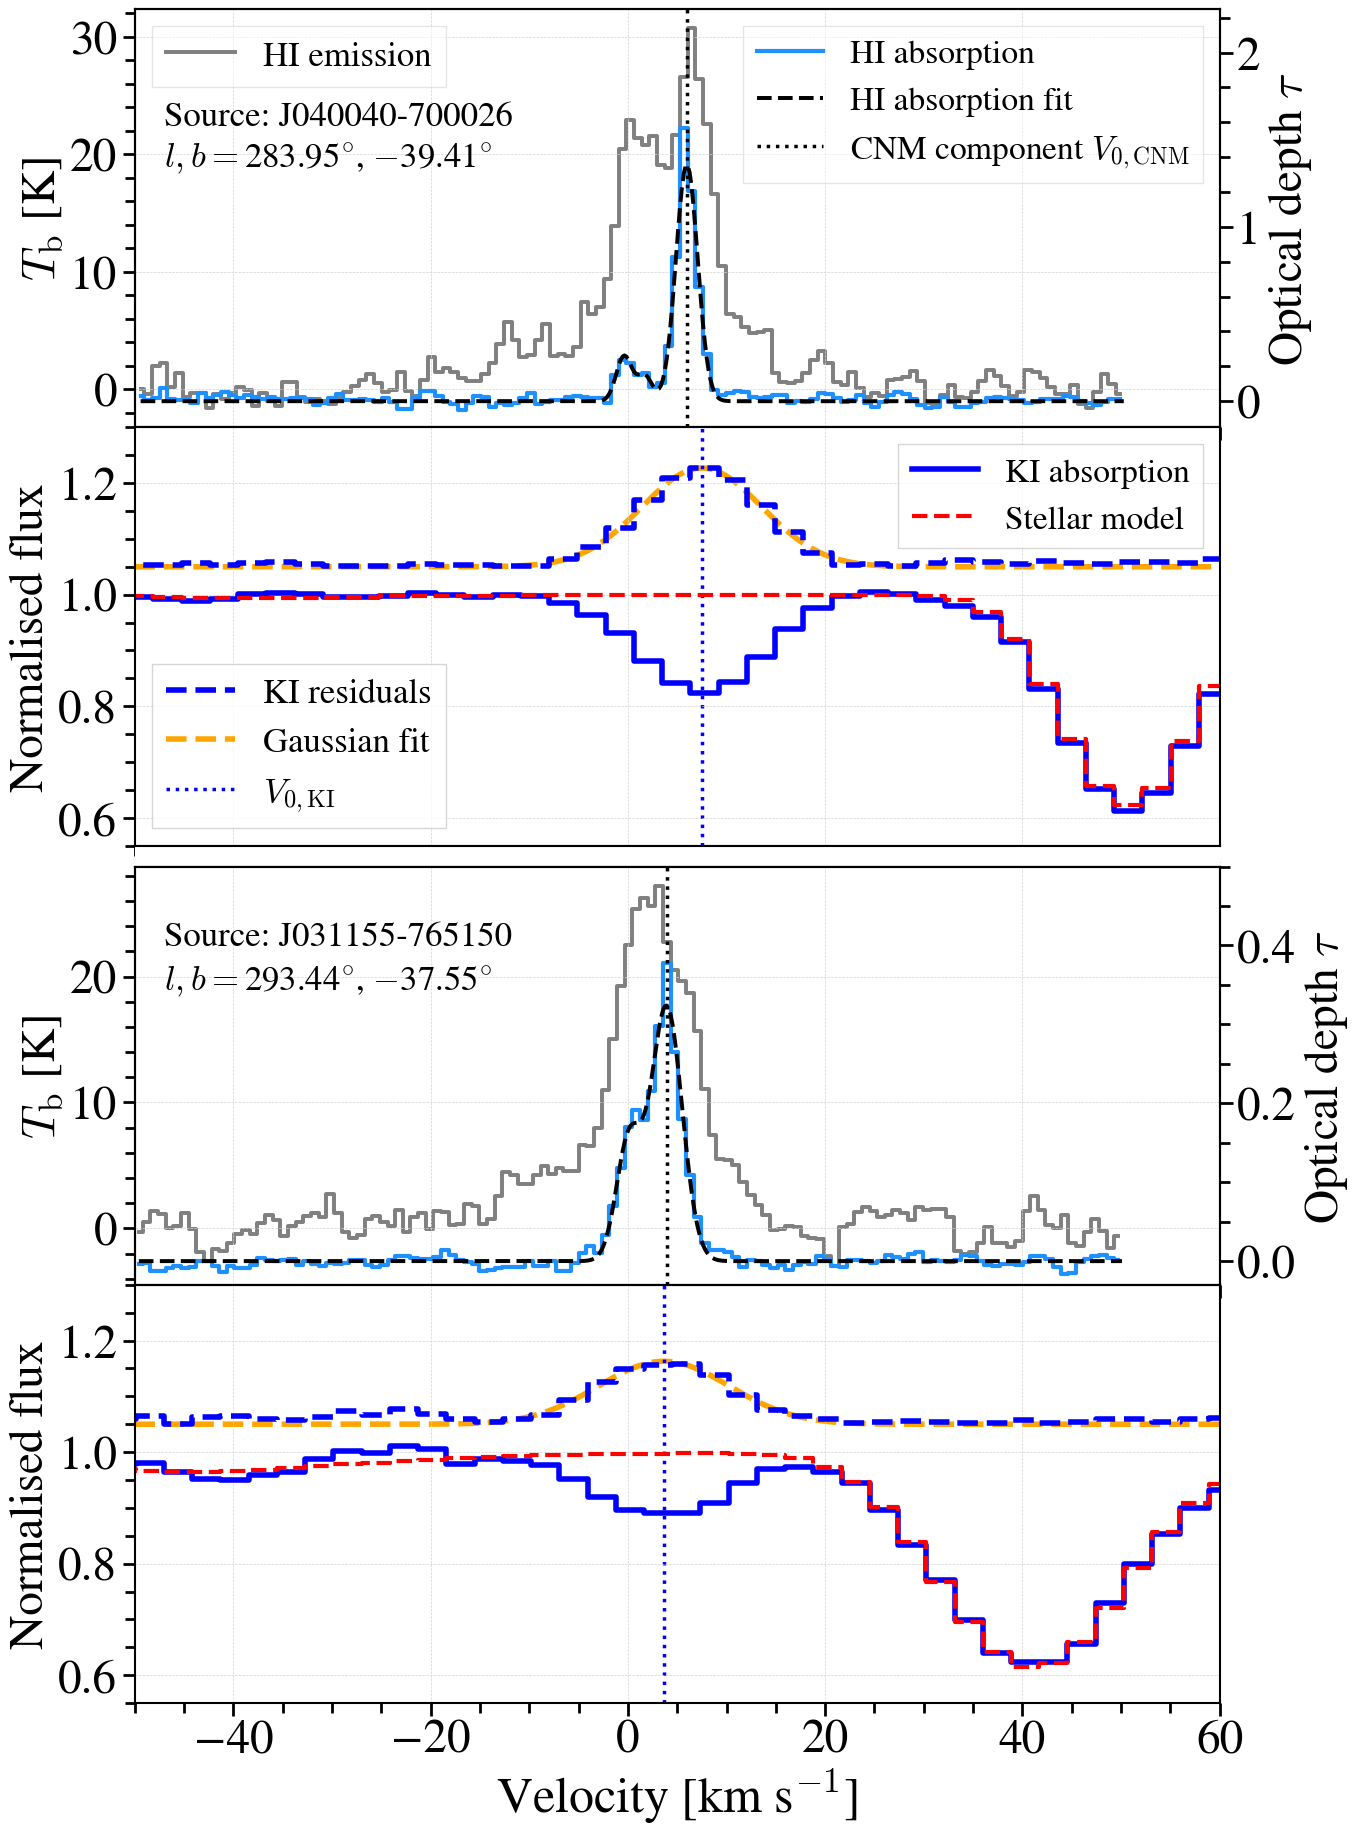

In [ ]:
import matplotlib.gridspec as gridspec
xfactors = {179:0.075, 376: 0.025}

sel_star_ids = {179:141104003801114, 104:140814006601004}


#######
# Grid plot
mpl.rcParams['axes.linewidth'] = 1.5

fig = plt.figure(figsize=(14,22))
gs = gridspec.GridSpec(81, 10)
ax = plt.subplot(gs[0:20, 0:10])
ax_cdf = plt.subplot(gs[20:40, 0:10], sharex=ax)
empty_ax = plt.subplot(gs[40:41, 0:10], sharex=ax)
ax1 = plt.subplot(gs[41:61, 0:10], sharex=ax)
ax1_cdf = plt.subplot(gs[61:, 0:10], sharex=ax1)


empty_ax.tick_params(axis='both', left=False, top=False, right=False, bottom=False, labelleft=False, labeltop=False, labelright=False, labelbottom=False)
empty_ax.tick_params(axis='y', left=False)
empty_ax.tick_params(axis='x', bottom=False)
empty_ax.spines['left'].set_visible(False)
empty_ax.spines['right'].set_visible(False)

xylabel = 36
xytlabel = 34


for hi_det_src_id in range(462):
    star_id = ggdf[ggdf.src_id == hi_det_src_id].star_id.values[0]

    if hi_det_src_id not in [104, 179]:
        continue


    # GASKAP source
    gaskap_src = df_det.iloc[hi_det_src_id]

    gaskap_src_name = gaskap_src.comp_name
    gaskap_field = gaskap_src.sbid

    src_glon = gaskap_src.glon
    src_glat = gaskap_src.glat
    print('ID: source (l,b): ', hi_det_src_id, src_glon, src_glat)


    # HI data: Open and load the pickle file
    gaskap_src_file = gaskap_hires_result_path / ('sb'+str(gaskap_field)) / f'{gaskap_src_name}.pkl'


    with open(gaskap_src_file, 'rb') as f:
        gaskap_res_data = pickle.load(f)


    gaskap_em_closest_em_profile = gaskap_res_data['EM_profiles'][:, 0]
    gaskap_em_avg_em_profile = np.mean(gaskap_res_data['EM_profiles'], axis=1)

    vlsr_gaskap = gaskap_res_data['vlsr_gaskap']
    sigemt_gaskap = gaskap_res_data['sigemt']
    emt_gaskap = gaskap_res_data['emt']

    ncnm = gaskap_res_data['ncnm']
    hgtcnm = gaskap_res_data['hgtcnm']
    cencnm = gaskap_res_data['cencnm']
    widcnm = gaskap_res_data['widcnm']

    # compute sum of gaussians
    hi_tau_arr = np.zeros_like(vlsr_gaskap)
    for i in range(ncnm):
        hi_tau_arr += gaussian(vlsr_gaskap, hgtcnm[i], cencnm[i], widcnm[i])


    # Assuming star_ids is a numpy array with star identifiers
    nearby_ids, nearby_coords = find_nearby_stars(glon_det[hi_det_src_id],
                                                  glat_det[hi_det_src_id],
                                                  glon,
                                                  glat,
                                                  star_ids,
                                                  radius
                                                  )
    n_nearby_stars = len(nearby_ids)
    print(f'GASKAP source {gaskap_src_name}: Found {n_nearby_stars} nearby stars')

    mask = np.isin(galah['sobject_id'], nearby_ids)
    selected_close_stars = galah[mask]


    # Find the associated KI absorption from nearby stars
    for k, (star_id, closest_coords_glon, closest_coords_glat, sep_distance) in enumerate(zip(nearby_ids, nearby_coords['glon'], nearby_coords['glat'], nearby_coords['distances'])):

        if star_id != sel_star_ids[hi_det_src_id]:
            continue

        closest_star_info = galah[galah['sobject_id'] == star_id]

        field_id = closest_star_info['field_id'].data[0]
        path = data_path / 'galah' / f'field_{field_id}'
        make_dir(path)

        sobject_id_str = str(star_id)
        output_star_id_file = path / f'{sobject_id_str}_allstar_fit_spectrum.fits'

        download_galah_data(path, star_id)

        # stellar data: wavelength, flux, model
        tmp_spec_table = Table.read(output_star_id_file)

        wavelength = tmp_spec_table['wave']
        flux = tmp_spec_table['sob']
        flux_mod = tmp_spec_table['smod']

        # for KI
        waverange_idx = np.where((wavelength > 7695.) & (wavelength < 7704.5))[0]
        ki_wavelength = np.array(wavelength[waverange_idx])
        ki_flux = np.array(flux[waverange_idx])
        ki_flux_mod = np.array(flux_mod[waverange_idx])

        star_glon = closest_star_info['l'].data[0]
        star_glat = closest_star_info['b'].data[0]

        star_rv_comp_1 = closest_star_info['rv_comp_1'].data[0] # km/s

        # Residuels, |model - data|
        res = np.abs(ki_flux_mod - ki_flux)
        max_res_id = np.argmax(res)
        ki_nu_max_res = ki_wavelength[max_res_id]


        # VSLRK of the max KI residual
        ki_ism_vlsr_obs = wavelength_to_vlsrk_with_galah_correction(ki_nu_max_res, lambda_rest, star_glon, star_glat, star_rv_comp_1, u_lsr=11.1, v_lsr=12.24, w_lsr=7.25)

        # the width of Ki absorption feature (in Angstrom)
        sigma_k_ism_star_val = closest_star_info['sigma_k_is'].data[0]
        sigma_k_ism_star_val_err = 0.1*sigma_k_ism_star_val
        vel_sigma_k_ism_val  = c*sigma_k_ism_star_val / lambda_rest
        vel_fwhm_k_ism_val   = 2 * np.sqrt(2 * np.log(2)) * vel_sigma_k_ism_val
        print('ISM KI line widths: ', sigma_k_ism_star_val, '(Angstrom),', vel_sigma_k_ism_val, '(km/s)')

        # the Equivalent width of Ki absorption feature (in Angstrom)
        ki_ew_ism_star_val = closest_star_info['ew_k_is'].data[0]

        # EW = sqrt(2pi) * A * sigma
        # the Amplitude of Ki absorption feature (flux vs Angstrom)
        ki_amp = ki_ew_ism_star_val / sigma_k_ism_star_val / np.sqrt(2.*np.pi) # See Sven's email "KI line depth from EW and width"
        ki_amp_err = 0.1 * ki_amp

        # Uncertainties in EW_KI
        ki_ew_ism_star_val_err = np.sqrt(2.*np.pi) * np.sqrt((sigma_k_ism_star_val*ki_amp_err)**2 + (ki_amp*sigma_k_ism_star_val_err)**2)
        print('KI Equivalent Width and Error: ', ki_ew_ism_star_val, ',', ki_ew_ism_star_val_err)

        # To VLSRK
        ki_xvlsr = wavelength_to_vlsrk_with_galah_correction(ki_wavelength, lambda_rest, star_glon, star_glat, star_rv_comp_1, u_lsr=11.1, v_lsr=12.24, w_lsr=7.25)


        ki_ew_ism_star = str(np.round(ki_ew_ism_star_val, 3))
        glon_star = np.round(closest_star_info['l'].data[0], 3)
        glat_star = np.round(closest_star_info['b'].data[0], 3)
        print('Star (l,b): ', glon_star, ',', glat_star)

        # distance to star
        star_med_dist = closest_star_info['r_med'].data[0] # pc

        # Given values
        # Convert angular separation to radians
        angular_sep_rad = np.radians(sep_distance)

        # Compute linear separation
        linear_sep_pc = med_dist * angular_sep_rad

        min_emt_id = np.argmin(emt_gaskap)
        emt_min_vlsr = vlsr_gaskap[min_emt_id]


        # KI residuals
        res = np.abs(ki_flux_mod - ki_flux)
        res_std = np.std( np.concatenate((res[:5], res[-5:])) )
        max_res_id = np.argmax(res)
        max_res_val = res[max_res_id]
        xvlsr_max_res = closest_star_info['ki_v_lsr_radio'].data[0] # From Gaussian fit now

        min_ki_mod_id = np.argmin(ki_flux_mod)
        ki_xvlsr_min_mod = ki_xvlsr[min_ki_mod_id]

        cencnm_idx = np.argmin(np.abs(cencnm - xvlsr_max_res))
        emt_min_vlsr = cencnm[cencnm_idx]
        vlsr_hi_ki_diff = np.abs(xvlsr_max_res - emt_min_vlsr) # compare HI absorption line with KI absorption velocity (using closest HI absorption line)


        if hi_det_src_id == 179:
            # Grid plot

            ## ax
            ax.step(vlsr_gaskap[::4], gaskap_em_closest_em_profile[::4], color='gray', ls='-', where='mid', zorder=-2, lw=2.85, label='HI emission')

            ax.text(-47, 22.5, 'Source: ' + gaskap_src_name, fontsize=25, color='k')
            ax.text(-47, 19, r'$l,b = $'+f'{src_glon:.2f}'+r'$^{\circ}$, '+ f'{src_glat:.2f}'.replace('-', '$-$')+r'$^{\circ}$', fontsize=25, color='k')

            ax.set_ylabel(r'$T_\mathrm{b}$ [K]', fontsize=xylabel-2)

            ax.minorticks_on()
            ax.tick_params(axis='x', labelsize=0, pad=2)
            ax.tick_params(axis='y', labelsize=xytlabel)
            ax.tick_params(which='both', width=2)
            ax.tick_params(which='major', length=9)
            ax.tick_params(which='minor', length=7)


            ax.grid(True, linestyle='--', linewidth=0.5, color='lightgray', zorder=-10)
            ax.legend(loc='upper left', fancybox=False, framealpha=0.5, labelcolor='k', fontsize=25)

            plt.setp(ax.get_xticklabels(), visible=False)

            ax.set_xlim(-50, 60.)
            # ax.set_xlim(-0.25, 33.)


            # instantiate a second Axes that shares the same x-axis
            ax2 = ax.twinx()

            ax2.step(vlsr_gaskap[::4], -np.log(emt_gaskap[::4]), color='dodgerblue', ls='-', where='mid', lw=3, zorder=0, label='HI absorption')
            ax2.plot(vlsr_gaskap, hi_tau_arr, 'k--', zorder=0, lw=2.85, label='HI absorption fit')
            ax2.axvline(x=cencnm[0], color='k', ls=':', zorder=1, lw=2.5, label=r'CNM component $V_\mathrm{0,CNM}$')


            ax2.minorticks_on()
            ax2.tick_params(axis='x', labelsize=xytlabel, pad=2)
            ax2.tick_params(axis='y', labelsize=xytlabel)
            ax2.tick_params(which='both', width=2)
            ax2.tick_params(which='major', length=9)
            ax2.tick_params(which='minor', length=7)

            ax2.set_ylabel(r'Optical depth $\tau$', color='k', fontsize=xylabel-2)
            ax2.tick_params(axis='y', labelcolor='k')
            ax2.set_xlim(-50, 60.)
            ax2.set_ylim(-0.15, 2.25)


            ax2.legend(loc='upper right', fancybox=False, framealpha=0.5, labelcolor='k', fontsize=24)



            # KI ax
            ki_lines = []
            ki_l1, = ax_cdf.step(ki_xvlsr, ki_flux, 'b-', lw=4, where='mid', label='KI absorption')
            ki_lines.append(ki_l1)
            ki_l1, = ax_cdf.step(ki_xvlsr, ki_flux_mod, 'r--', lw=3, where='mid', label='Stellar model')
            ki_lines.append(ki_l1)

            ki_lines2 = []
            ki_l1, = ax_cdf.step(ki_xvlsr, 1.05 + res, 'b--', lw=4, where='mid', label=r'KI residuals') # | model - data |
            ki_lines2.append(ki_l1)

            gaussian_curve = gaussian(velocity_range, ki_amp, xvlsr_max_res, vel_fwhm_k_ism_val)
            ki_l1, = ax_cdf.plot(velocity_range, 1.05 + gaussian_curve, color='orange', ls='--', zorder=1, lw=4, label='Gaussian fit')
            ki_lines2.append(ki_l1)

            ki_l1 = ax_cdf.axvline(x=xvlsr_max_res, color='b', ls=':', zorder=1, lw=2.5, label=r'$V_\mathrm{0, KI}$')
            ki_lines2.append(ki_l1)


            # xyticks
            ax_cdf.minorticks_on()
            ax_cdf.tick_params(axis='x', labelsize=0, pad=2)
            ax_cdf.tick_params(axis='y', labelsize=xytlabel)
            ax_cdf.tick_params(axis='x', bottom=False)
            ax_cdf.tick_params(which='both', width=2)
            ax_cdf.tick_params(which='major', length=9)
            ax_cdf.tick_params(which='minor', length=7)

            ax_cdf.set_ylim(0.55,1.3)
            ax_cdf.set_xlim(-50, 60.)

            ax_cdf.set_ylabel('Normalised flux', fontsize=xylabel-2)

            ax_cdf.tick_params('y', colors='k')
            ax_cdf.grid(True, linestyle='--', linewidth=0.5, color='lightgray', zorder=-10)

            first_legend = ax_cdf.legend(handles=ki_lines, loc='upper right', fancybox=False, framealpha=0.8, labelcolor='k', fontsize=24.)
            ax_cdf.add_artist(first_legend)

            ax_cdf.legend(handles=ki_lines2, loc='lower left', fancybox=False, framealpha=0.8, labelcolor='k', fontsize=25.)


        if hi_det_src_id == 104:
            # Grid plot

            ## ax1
            ax1.step(vlsr_gaskap[::4], gaskap_em_closest_em_profile[::4], color='gray', ls='-', where='mid', zorder=-2, lw=2.85, label='HI emission')

            ax1.text(-47, 22.5, 'Source: ' + gaskap_src_name, fontsize=25, color='k')
            ax1.text(-47, 19, r'$l,b = $'+f'{src_glon:.2f}'+r'$^{\circ}$, '+ f'{src_glat:.2f}'.replace('-', '$-$')+r'$^{\circ}$', fontsize=25, color='k')

            ax1.set_ylabel(r'$T_\mathrm{b}$ [K]', fontsize=xylabel-2)

            ax1.minorticks_on()
            ax1.tick_params(axis='x', labelsize=xytlabel, pad=2)
            ax1.tick_params(axis='y', labelsize=xytlabel)
            ax1.tick_params(which='both', width=2)
            ax1.tick_params(which='major', length=9)
            ax1.tick_params(which='minor', length=7)


            ax1.grid(True, linestyle='--', linewidth=0.5, color='lightgray', zorder=-10)

            plt.setp(ax1.get_xticklabels(), visible=False)

            ax1.set_xlim(-50, 60.)
            ax1.set_xlim(-0, 28.)


            # instantiate a second Axes that shares the same x-axis
            ax12 = ax1.twinx()

            ax12.step(vlsr_gaskap[::4], -np.log(emt_gaskap[::4]), color='dodgerblue', ls='-', where='mid', lw=3, zorder=0, label='HI absorption')
            ax12.plot(vlsr_gaskap, hi_tau_arr, 'k--', zorder=0, lw=2.85, label='HI absorption fit')
            ax12.axvline(x=cencnm[0], color='k', ls=':', zorder=1, lw=2.5, label=r'CNM component $V_\mathrm{0,CNM}$')


            ax12.minorticks_on()
            ax12.tick_params(axis='x', labelsize=xytlabel, pad=2)
            ax12.tick_params(axis='y', labelsize=xytlabel)
            ax12.tick_params(which='both', width=2)
            ax12.tick_params(which='major', length=9)
            ax12.tick_params(which='minor', length=7)

            ax12.set_ylabel(r'Optical depth $\tau$', color='k', fontsize=xylabel-2)
            ax12.tick_params(axis='y', labelcolor='k')
            ax12.set_xlim(-60, 60.)
            ax12.set_ylim(-0.03, 0.5)



            # KI ax2
            ki_lines = []
            ki_l1, = ax1_cdf.step(ki_xvlsr, ki_flux, 'b-', lw=4, where='mid', label='KI absorption')
            ki_lines.append(ki_l1)
            ki_l1, = ax1_cdf.step(ki_xvlsr, ki_flux_mod, 'r--', lw=3, where='mid', label='Stellar model')
            ki_lines.append(ki_l1)

            ki_lines2 = []
            ki_l1, = ax1_cdf.step(ki_xvlsr, 1.05 + res, 'b--', lw=4, where='mid', label=r'KI residuals') # | model - data |
            ki_lines2.append(ki_l1)

            gaussian_curve = gaussian(velocity_range, ki_amp, xvlsr_max_res, vel_fwhm_k_ism_val)
            ki_l1, = ax1_cdf.plot(velocity_range, 1.05 + gaussian_curve, color='orange', ls='--', zorder=1, lw=4, label='Gaussian fit')
            ki_lines2.append(ki_l1)

            ki_l1 = ax1_cdf.axvline(x=xvlsr_max_res, color='b', ls=':', zorder=1, lw=2.5, label=r'$V_\mathrm{0, KI}$')
            ki_lines2.append(ki_l1)


            # xyticks
            ax1_cdf.minorticks_on()
            ax1_cdf.tick_params(axis='x', labelsize=xytlabel, pad=2)
            ax1_cdf.tick_params(axis='y', labelsize=xytlabel)
            ax1_cdf.tick_params(which='both', width=2)
            ax1_cdf.tick_params(which='major', length=9)
            ax1_cdf.tick_params(which='minor', length=7)

            ax1_cdf.set_ylim(0.55,1.3)
            ax1_cdf.set_xlim(-50, 60.)

            ax1_cdf.set_xlabel(r'Velocity [km s$^{-1}$]', fontsize=xylabel)
            ax1_cdf.set_ylabel('Normalised flux', fontsize=xylabel-2)

            ax1_cdf.tick_params('y', colors='k')
            ax1_cdf.grid(True, linestyle='--', linewidth=0.5, color='lightgray', zorder=-10)

            ax1.set_xlim(-50, 60.)
    # End - if: plot
    print()

# set the spacing between subplots
plt.subplots_adjust(left=None,
                    bottom=None,
                    right=None,
                    top=None,
                    wspace=0.,
                    hspace=0.
                    )

# plt.tight_layout()
plt.show()
plt.close()
# End - for: GASKAP abs sources

<>:185: SyntaxWarning:

invalid escape sequence '\m'

<>:185: SyntaxWarning:

invalid escape sequence '\m'

/tmp/ipython-input-1512214113.py:185: SyntaxWarning:

invalid escape sequence '\m'



src_glon, src_glat:  344 286.3525731639229 -32.41128885066119
GASKAP src J051446-744126: Found 12 nearby stars
ISM KI widths:  0.1672214 6.511488004332666
KI gaussian_amp:  0.09184585509233338 0.009184585509233338
KI EW:  0.038498282 0.005444479364075265
glon_star, glat_star 286.162 -32.491


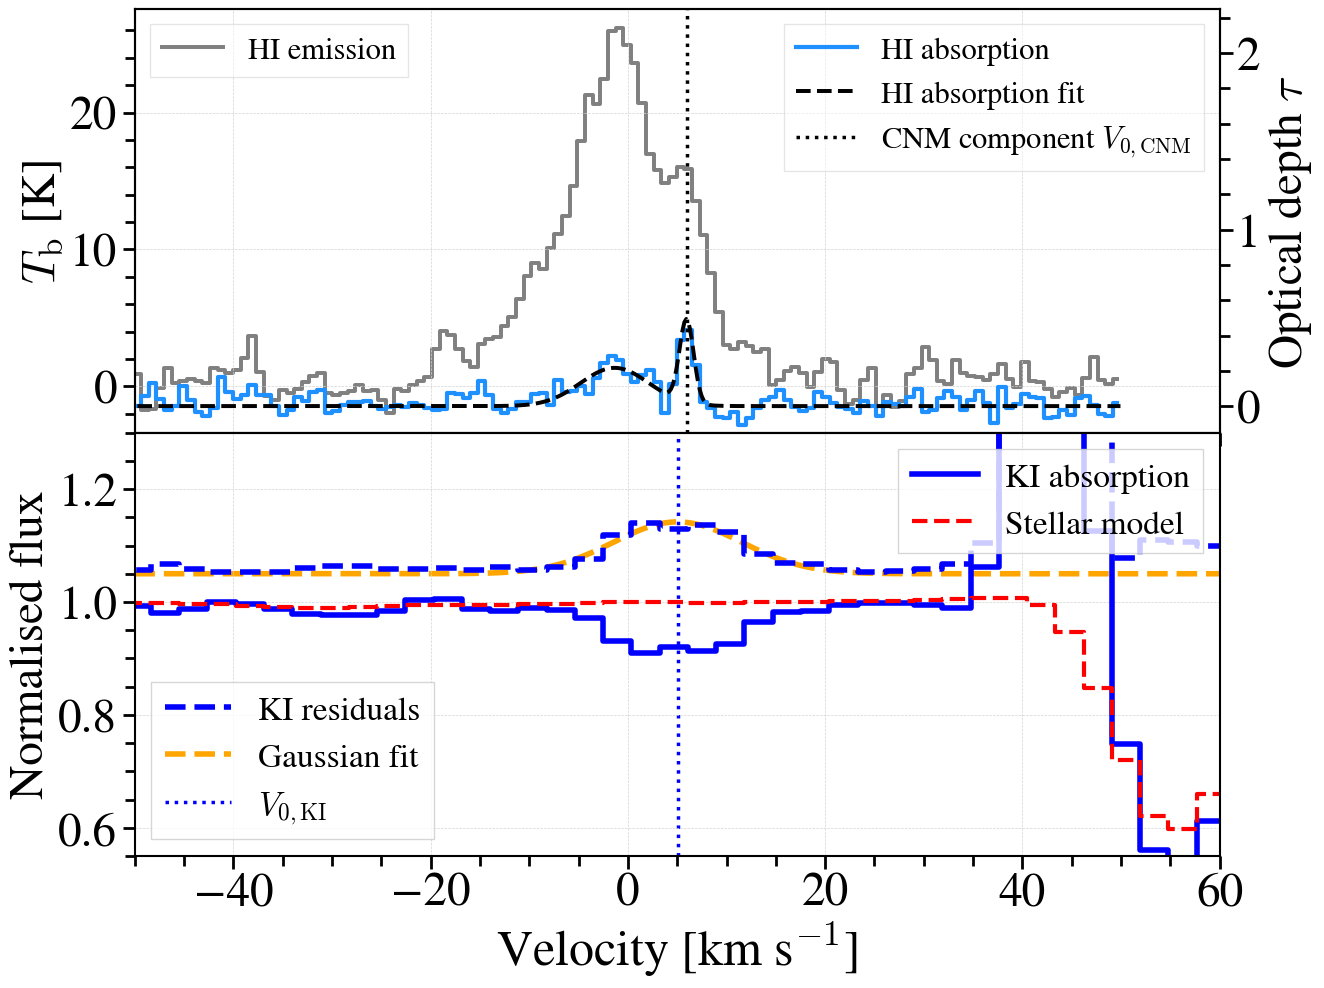

In [ ]:
import matplotlib.gridspec as gridspec
xfactors = {179:0.075, 376: 0.025}

# GASKAP source

gaskap_src_name = 'J051446-744126'
gaskap_field = gaskap_src.sbid

src_glon = gaskap_src.glon
src_glat = gaskap_src.glat
print('src_glon, src_glat: ', hi_det_src_id, src_glon, src_glat)


# HI data: Open and load the pickle file
gaskap_src_file = gaskap_hires_result_path / ('sb'+str(gaskap_field)) / f'{gaskap_src_name}.pkl'


with open(gaskap_src_file, 'rb') as f:  # "rb" mode means read in binary
    gaskap_res_data = pickle.load(f)


gaskap_em_closest_em_profile = gaskap_res_data['EM_profiles'][:, 0]
gaskap_em_avg_em_profile = np.mean(gaskap_res_data['EM_profiles'], axis=1)

vlsr_gaskap = gaskap_res_data['vlsr_gaskap']
sigemt_gaskap = gaskap_res_data['sigemt']
emt_gaskap = gaskap_res_data['emt']

ncnm = gaskap_res_data['ncnm']
hgtcnm = gaskap_res_data['hgtcnm']
cencnm = gaskap_res_data['cencnm']
widcnm = gaskap_res_data['widcnm']

# compute sum of gaussians
hi_tau_arr = np.zeros_like(vlsr_gaskap)
for i in range(ncnm):
    hi_tau_arr += gaussian(vlsr_gaskap, hgtcnm[i], cencnm[i], widcnm[i])


# Assuming star_ids is a numpy array with star identifiers
nearby_ids, nearby_coords = find_nearby_stars(glon_det[hi_det_src_id],
                                              glat_det[hi_det_src_id],
                                              glon,
                                              glat,
                                              star_ids,
                                              radius
                                              )
n_nearby_stars = len(nearby_ids)
print(f'GASKAP src {gaskap_src_name}: Found {n_nearby_stars} nearby stars')

mask = np.isin(galah['sobject_id'], nearby_ids)
selected_close_stars = galah[mask]


# Matched star
star_id = 180101003601161:

closest_star_info = galah[galah['sobject_id'] == star_id]

field_id = closest_star_info['field_id'].data[0]
path = data_path / 'galah' / f'field_{field_id}'
make_dir(path)

sobject_id_str = str(star_id)
output_star_id_file = path / f'{sobject_id_str}_allstar_fit_spectrum.fits'

download_galah_data(path, star_id)

# stellar data: wavelength, flux, model
tmp_spec_table = Table.read(output_star_id_file)

wavelength = tmp_spec_table['wave']
flux = tmp_spec_table['sob']
flux_mod = tmp_spec_table['smod']

# for KI
waverange_idx = np.where((wavelength > 7695.) & (wavelength < 7704.5))[0] # 7720
ki_wavelength = np.array(wavelength[waverange_idx])
ki_flux = np.array(flux[waverange_idx])
ki_flux_mod = np.array(flux_mod[waverange_idx])

star_glon = closest_star_info['l'].data[0]
star_glat = closest_star_info['b'].data[0]

star_rv_comp_1 = closest_star_info['rv_comp_1'].data[0] # km/s

# Residuels, |model - data|
res = np.abs(ki_flux_mod - ki_flux)
max_res_id = np.argmax(res)
ki_nu_max_res = ki_wavelength[max_res_id]


# VSLRK of the max KI residual
ki_ism_vlsr_obs = wavelength_to_vlsrk_with_galah_correction(ki_nu_max_res, lambda_rest, star_glon, star_glat, star_rv_comp_1, u_lsr=11.1, v_lsr=12.24, w_lsr=7.25)

# the width of Ki absorption feature (in Angstrom)
sigma_k_ism_star_val = closest_star_info['sigma_k_is'].data[0]
sigma_k_ism_star_val_err = 0.1*sigma_k_ism_star_val
vel_sigma_k_ism_val  = c*sigma_k_ism_star_val / lambda_rest
vel_fwhm_k_ism_val   = 2 * np.sqrt(2 * np.log(2)) * vel_sigma_k_ism_val
print('ISM KI widths: ', sigma_k_ism_star_val, vel_sigma_k_ism_val)

# the Equivalent width of Ki absorption feature (in Angstrom)
ki_ew_ism_star_val = closest_star_info['ew_k_is'].data[0]

# EW = sqrt(2pi) * A * sigma
# the Amplitude of Ki absorption feature (flux vs Angstrom)
ki_amp = ki_ew_ism_star_val / sigma_k_ism_star_val / np.sqrt(2.*np.pi) # See Sven's email "KI line depth from EW and width"
ki_amp_err = 0.1 * ki_amp
print('KI gaussian_amp: ', ki_amp, ki_amp_err)

# Uncertainties in EW_KI
ki_ew_ism_star_val_err = np.sqrt(2.*np.pi) * np.sqrt((sigma_k_ism_star_val*ki_amp_err)**2 + (ki_amp*sigma_k_ism_star_val_err)**2)
print('KI EW: ', ki_ew_ism_star_val, ki_ew_ism_star_val_err)

# To VLSRK
ki_xvlsr = wavelength_to_vlsrk_with_galah_correction(ki_wavelength, lambda_rest, star_glon, star_glat, star_rv_comp_1, u_lsr=11.1, v_lsr=12.24, w_lsr=7.25)


ki_ew_ism_star = str(np.round(ki_ew_ism_star_val, 3))
glon_star = np.round(closest_star_info['l'].data[0], 3)
glat_star = np.round(closest_star_info['b'].data[0], 3)
print('glon_star, glat_star', glon_star, glat_star)

# distance to star
star_med_dist = closest_star_info['r_med'].data[0] # pc

# Given values
# Convert angular separation to radians
angular_sep_rad = np.radians(sep_distance)

# Compute linear separation
linear_sep_pc = med_dist * angular_sep_rad

min_emt_id = np.argmin(emt_gaskap)
emt_min_vlsr = vlsr_gaskap[min_emt_id]


# KI residuals
res = np.abs(ki_flux_mod - ki_flux)
res_std = np.std( np.concatenate((res[:5], res[-5:])) )
max_res_id = np.argmax(res)
max_res_val = res[max_res_id]
xvlsr_max_res = closest_star_info['ki_v_lsr_radio'].data[0]

min_ki_mod_id = np.argmin(ki_flux_mod)
ki_xvlsr_min_mod = ki_xvlsr[min_ki_mod_id]

cencnm_idx = np.argmin(np.abs(cencnm - xvlsr_max_res))
emt_min_vlsr = cencnm[cencnm_idx]
vlsr_hi_ki_diff = np.abs(xvlsr_max_res - emt_min_vlsr) # compare HI absorption line with KI absorption velocity (using closest HI absorption line)




## Plot
if True:
    #######
    # Grid plot
    mpl.rcParams['axes.linewidth'] = 1.5

    fig = plt.figure(figsize=(14,11))
    gs = gridspec.GridSpec(10, 10)
    ax = plt.subplot(gs[0:5, 0:10])
    ax_cdf = plt.subplot(gs[5:, 0:10],sharex=ax)

    xylabel = 36
    xytlabel = 34

    ## ax
    ax.step(vlsr_gaskap[::4], gaskap_em_closest_em_profile[::4], color='gray', ls='-', where='mid', zorder=-2, lw=2.85, label='HI emission')

    ax.set_ylabel('$T_\mathrm{b}$ [K]', fontsize=xylabel-2)

    ax.minorticks_on()
    ax.tick_params(axis='x', labelsize=xytlabel, pad=2)
    ax.tick_params(axis='y', labelsize=xytlabel)
    ax.tick_params(which='both', width=2)
    ax.tick_params(which='major', length=9)
    ax.tick_params(which='minor', length=7)


    ax.grid(True, linestyle='--', linewidth=0.5, color='lightgray', zorder=-10)
    ax.legend(loc='upper left', fancybox=False, framealpha=0.5, labelcolor='k', fontsize=22)

    plt.setp(ax.get_xticklabels(), visible=False)

    ax.set_xlim(-60, 60.)
    # ax.set_xlim(-0.25, 33.)


    ax2 = ax.twinx()  # instantiate a second Axes that shares the same x-axis

    ax2.step(vlsr_gaskap[::4], -np.log(emt_gaskap[::4]), color='dodgerblue', ls='-', where='mid', lw=3, zorder=0, label='HI absorption')
    ax2.plot(vlsr_gaskap, hi_tau_arr, 'k--', zorder=0, lw=2.85, label='HI absorption fit') # GASKAP absorption fit
    ax2.axvline(x=cencnm[0], color='k', ls=':', zorder=1, lw=2.5, label=r'CNM component $V_\mathrm{0,CNM}$')


    ax2.minorticks_on()
    ax2.tick_params(axis='x', labelsize=xytlabel, pad=2)
    ax2.tick_params(axis='y', labelsize=xytlabel)
    ax2.tick_params(which='both', width=2)
    ax2.tick_params(which='major', length=9)
    ax2.tick_params(which='minor', length=7)

    ax2.set_ylabel(r'Optical depth $\tau$', color='k', fontsize=xylabel-2)  # we already handled the x-label with ax1
    ax2.tick_params(axis='y', labelcolor='k')
    ax2.set_xlim(-60, 60.)
    ax2.set_ylim(-0.15, 2.25)


    # ax2.grid(True, linestyle='--', linewidth=0.5, color='lightgray', zorder=-10)
    ax2.legend(loc='upper right', fancybox=False, framealpha=0.5, labelcolor='k', fontsize=22)



    # KI ax
    ki_lines = []
    ki_l1, = ax_cdf.step(ki_xvlsr, ki_flux, 'b-', lw=4, where='mid', label='KI absorption')
    ki_lines.append(ki_l1)
    ki_l1, = ax_cdf.step(ki_xvlsr, ki_flux_mod, 'r--', lw=3, where='mid', label='Stellar model')
    ki_lines.append(ki_l1)

    ki_lines2 = []
    ki_l1, = ax_cdf.step(ki_xvlsr, 1.05 + res, 'b--', lw=4, where='mid', label=r'KI residuals') # | model - data |
    ki_lines2.append(ki_l1)

    gaussian_curve = gaussian(velocity_range, ki_amp, xvlsr_max_res, vel_fwhm_k_ism_val)
    ki_l1, = ax_cdf.plot(velocity_range, 1.05 + gaussian_curve, color='orange', ls='--', zorder=1, lw=4, label='Gaussian fit')
    ki_lines2.append(ki_l1)

    ki_l1 = ax_cdf.axvline(x=xvlsr_max_res, color='b', ls=':', zorder=1, lw=2.5, label=r'$V_\mathrm{0, KI}$')
    ki_lines2.append(ki_l1)


    # xyticks
    ax_cdf.minorticks_on()
    ax_cdf.tick_params(axis='x', labelsize=xytlabel, pad=2)
    ax_cdf.tick_params(axis='y', labelsize=xytlabel)
    ax_cdf.tick_params(which='both', width=2)
    ax_cdf.tick_params(which='major', length=9)
    ax_cdf.tick_params(which='minor', length=7)

    ax_cdf.set_ylim(0.55,1.3)
    ax_cdf.set_xlim(-50, 60.)

    ax_cdf.set_xlabel(r'Velocity [km s$^{-1}$]', fontsize=xylabel)
    ax_cdf.set_ylabel('Normalised flux', fontsize=xylabel-2)

    ax_cdf.tick_params('y', colors='k')
    ax_cdf.grid(True, linestyle='--', linewidth=0.5, color='lightgray', zorder=-10)

    first_legend = ax_cdf.legend(handles=ki_lines, loc='upper right', fancybox=False, framealpha=0.8, labelcolor='k', fontsize=24.)
    ax_cdf.add_artist(first_legend)

    ax_cdf.legend(handles=ki_lines2, loc='lower left', fancybox=False, framealpha=0.8, labelcolor='k', fontsize=24.)


    ax.set_xlim(-50, 60.)

    ymin_flux = np.min(np.min(flux_mod))
    ymax_flux = np.max(flux)

    # set the spacing between subplots
    plt.subplots_adjust(left=None,
                        bottom=None,
                        right=None,
                        top=None,
                        wspace=0.,
                        hspace=0.
                        )

    # Save: spectra_eg.png
    # plt.tight_layout()
    plt.show()
    plt.close()
# End - if: plot
print()